# 必要な計算環境

* Linux OS
* Pascal, Volta, Turing, 或いは NVIDIA Ampere 世代 GPU
* Nvidia Driver
* Docker

# 事前準備

* [NGC](https://catalog.ngc.nvidia.com/?filters=&orderBy=weightPopularDESC&query=&page=&pageSize=)の登録と[APIキー](https://org.ngc.nvidia.com/setup/api-key)の取得は済みましたか？
* [Weights and Biases]((https://docs.wandb.ai/quickstart)) の登録と[APIキー](https://docs.wandb.ai/guides/track/public-api-guide#authentication)の取得は済みましたか？

### NGC のセットアップ
NGCからモデルをダウンロードしたい場合は、APIキーが必要になりますので、取得してください。
### Weights and Biases のセットアップ
モデルのトレーニング進行状況やチャートは、 [Weights and Biases](https://docs.wandb.ai/quickstart) を通じて可視化できます。ログを有効にするために、 [API キー](https://docs.wandb.ai/guides/track/public-api-guide#authentication)を設定してください。

In [1]:
import os
#os.environ["WANDB_ENTITY"]="wandb-healthcare"
os.environ["WANDB_PROJECT"]="BioNeMo_Molecule_LLM"

# GPUの確認

In [2]:
!nvidia-smi

Wed Jul 17 01:36:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:0F:00.0 Off |                    0 |
| N/A   25C    P0              50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# データの前処理

BioNeMo Frameworkのモデルトレーニング機能を簡単に紹介するために、サンプルデータセットとして提供されている元のZINC15データセットの非常に小さなサブセットを使用します。このサブセットは、下記のコマンドを実行することで、 /workspace/bionemo/examples/molecule/molmim/data に保存します。

このテスト実行のために、フォルダには/train、/val、/testの各フォルダが含まれており、それぞれのフォルダにはCSVファイル形式のSMILESの分子構造式が含まれています。これらのディレクトリ内で、それぞれ何ファイルが作成されたかを確認し、以下の例のコマンドにおける TRAIN_FILE_RANGE、VAL_FILE_RANGE、TEST_FILE_RANGE のパラメータをそれに応じて修正してください。現在のコマンド設定では、train、val および test ディレクトリには 1 ファイルずつが扱われるように設定され、それぞれが299069、2、1486個のサンプルが含まれています。

In [3]:
cd /workspace/bionemo

/workspace/bionemo


In [42]:
!python examples/molecule/molmim/pretrain.py\
 --config-path conf\
 --config-name molmim_70m_24_3\
 ++do_training=False\
 ++trainer.devices=1 \
 ++trainer.num_nodes=1 \
 ++model.data.dataset_path=/workspace/bionemo/examples/molecule/molmim/data \
 ++model.data.links_file=/workspace/bionemo/examples/molecule/megamolbart/dataset/ZINC-downloader-sample.txt \
 ++exp_manager.create_wandb_logger=False \
 ++exp_manager.exp_dir=/workspace/bionemo/results/logs/

[NeMo I 2024-07-17 10:59:59 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-07-17 10:59:59 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-07-17 11:00:00 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-07-17 11:00:00 pretrain:25] 
    
    ************** Experiment configuration ***********
[NeMo I 2024-07-17 11:00:00 pretrain:26] 
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
        ffn_hidden_size: ${multiply:${.hidden_size}, 4}
        num_attention_heads:

In [23]:
"""
import wandb
with wandb.init(name="data_upload") as run:
    artifact = wandb.Artifact(
        name="small_ZINC",
        type="dataset",
        description="subset of ZINC",
        metadata={"path":"/workspace/bionemo/examples/molecule/molmim/data"},
    )
    artifact.add_dir("/workspace/bionemo/examples/molecule/molmim/data")
    run.log_artifact(artifact)
"""

'\nimport wandb\nwith wandb.init(name="data_upload") as run:\n    artifact = wandb.Artifact(\n        name="small_ZINC",\n        type="dataset",\n        description="subset of ZINC",\n        metadata={"path":"/workspace/bionemo/examples/molecule/molmim/data"},\n    )\n    artifact.add_dir("/workspace/bionemo/examples/molecule/molmim/data")\n    run.log_artifact(artifact)\n'

# モデルの事前学習

このテスト実行では、/workspace/bionemo/examples/molecule/molmim/conf フォルダにある pretrain_small_canonicalized_logv.yaml 設定ファイルに提供されている事前設定されたパラメータを使用します。これは、MolMIM-70M-24.3 チェックポイントをトレーニングするために使用された設定です。

In [24]:
cd /workspace/bionemo 

/workspace/bionemo


データのサイズによって、TRAIN_FILE_RANGE、TEST_FILE_RANGE、VAL_FILE_RANGEを設定してください。

In [25]:
#TRAIN_FILE_RANGE="x_OP_000..175_CL_"
#TEST_FILE_RANGE="x_OP_000..004_CL_"
#VAL_FILE_RANGE="x_OP_000..175_CL_"

TRAIN_FILE_RANGE="x000"
TEST_FILE_RANGE="x000"
VAL_FILE_RANGE="x000"

In [26]:
import os
os.environ["HYDRA_FULL_ERROR"]="1"

In [27]:
!python examples/molecule/molmim/pretrain.py\
 --config-path conf\
 --config-name molmim_70m_24_3\
 ++trainer.devices=1 \
 ++trainer.num_nodes=1 \
 ++trainer.max_steps=1000 \
 ++trainer.accumulate_grad_batches=1 \
 ++trainer.val_check_interval=5 \
 ++trainer.limit_val_batches=1.0 \
 ++trainer.precision=32 \
 ++model.micro_batch_size=128 \
 ++model.global_batch_size=128 \
 ++model.dwnstr_task_validation.enabled=False \
 ++model.data.dataset_path=examples/molecule/molmim/data \
 ++model.data.dataset.train=$TRAIN_FILE_RANGE \
 ++model.data.dataset.val=$VAL_FILE_RANGE \
 ++model.data.dataset.test=$TEST_FILE_RANGE \
 ++model.data.index_mapping_dir=/results/data_index/ \
 ++model.seq_length=128 \
 ++exp_manager.exp_dir=/results/logs/ \
 ++exp_manager.create_wandb_logger=False

[NeMo I 2024-07-17 01:59:36 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-07-17 01:59:36 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-07-17 01:59:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-07-17 01:59:36 pretrain:25] 
    
    ************** Experiment configuration ***********
[NeMo I 2024-07-17 01:59:36 pretrain:26] 
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
        ffn_hidden_size: ${multiply:${.hidden_size}, 4}
        num_attention_heads:

# CMA-ESを使用したMolMIMによる特性ガイド分子最適化

このセッションは、BioNeMo Framework からMolMIMのチェックポイントをロードし、カスタムのユーザー定義スコアリング機能を使用して興味のあるいくつかの分子を最適化する方法を示します。CMA-ESを使用してMolMIMモデルの潜在空間をトラバースし、スコアリング機能によって測定されたパフォーマンスを向上させると期待される新しい関連分子を選択します。これらの分子をサンプリングするためには、以下のステップを完了する必要があります：

1. 望むMolMIMチェックポイントをロードする。

2. 開始分子をMolMIMの潜在空間にエンコードする。

3. CMA-ESを実行し、以下を繰り返し実行する：

    * 潜在表現をSMILES文字列にデコードする。
    * これらのSMILES文字列にユーザー定義のスコアリング機能を適用し、SMILES/スコアのペアを生成する。
    * 新しい潜在空間表現のセットをCMA-ESアルゴリズムに要求する。

では、事前学習済みモデルをダウンロードします。モデルをダウンロードするため、ngc をインストールして、ngc config を設定する必要があります。

In [28]:
import os
#os.environ["WANDB_ENTITY"]="wandb-healthcare"
os.environ["WANDB_PROJECT"]="BioNeMo_Molecure_optimization"

In [29]:
!pip install optuna statsmodels -qqq

In [30]:
!wget -q -O /tmp/ngccli_linux.zip --content-disposition https://api.ngc.nvidia.com/v2/resources/nvidia/ngc-apps/ngc_cli/versions/3.38.0/files/ngccli_linux.zip && unzip -o /tmp/ngccli_linux.zip -d /tmp && chmod u+x /tmp/ngc-cli/ngc && rm /tmp/ngccli_linux.zip

Archive:  /tmp/ngccli_linux.zip
  inflating: /tmp/ngc-cli/boto3/examples/s3.rst  
  inflating: /tmp/ngc-cli/boto3/examples/cloudfront.rst  
  inflating: /tmp/ngc-cli/boto3/data/dynamodb/2012-08-10/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/sqs/2012-11-05/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/opsworks/2013-02-18/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/iam/2010-05-08/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2014-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-03-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-09-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-04-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-04-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-11-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/s3/2006-03-01/resources-1.json  

そして、ターミナルを開いて、下記のコマンドを入力して、 ngc config set をしてください。

/tmp/ngc-cli/ngc config set

<順番にAPI キー、CLI output format, org, team, aceを入力してください。API キーはNGCのAPIキーを入力してください。Org は ’no-org’ 以外のものを選択して、その他は「Enter」でデフォルト値を入力すれば大丈夫です>

最後に、下記のコマンドを入力すれば、モデルをダウンロードできます。

In [31]:
cd /workspace/bionemo 

/workspace/bionemo


In [32]:
!python download_models.py --download_dir /workspace/bionemo/models molmim_70m_24_3

Running command: ngc --version

Installing NGC CLI to /tmp
Running command: wget -q -O /tmp/ngccli_linux.zip --content-disposition https://api.ngc.nvidia.com/v2/resources/nvidia/ngc-apps/ngc_cli/versions/3.38.0/files/ngccli_linux.zip && unzip -o /tmp/ngccli_linux.zip -d /tmp && chmod u+x /tmp/ngc-cli/ngc && rm /tmp/ngccli_linux.zip

Archive:  /tmp/ngccli_linux.zip
  inflating: /tmp/ngc-cli/boto3/examples/s3.rst  
  inflating: /tmp/ngc-cli/boto3/examples/cloudfront.rst  
  inflating: /tmp/ngc-cli/boto3/data/dynamodb/2012-08-10/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/sqs/2012-11-05/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/opsworks/2013-02-18/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/iam/2010-05-08/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2014-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-03-01/resources-1.json  
  inflating: /tmp/

## チェックポイントをmolmim推論ラッパーにロード

In [33]:
from bionemo.utils.hydra import load_model_config
import os
from bionemo.model.molecule.molmim.infer import MolMIMInference
bionemo_home=f"/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
checkpoint_path = f"{bionemo_home}/models/molecule/molmim/molmim_70m_24_3.nemo"
cfg = load_model_config(config_name="molmim_infer.yaml", config_path=f"{bionemo_home}/examples/tests/conf/") # reasonable starting config for molmim inference
# This is the field of the config that we need to set to our desired checkpoint path.
cfg.model.downstream_task.restore_from_path = checkpoint_path
model = MolMIMInference(cfg, interactive=True)

[NeMo I 2024-07-17 01:59:52 utils:333] Restoring model from /workspace/bionemo/models/molecule/molmim/molmim_70m_24_3.nemo
[NeMo I 2024-07-17 01:59:52 utils:337] Loading model class: bionemo.model.molecule.molmim.molmim_model.MolMIMModel


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Interactive mode selected, using strategy='auto'
[NeMo I 2024-07-17 01:59:52 exp_manager:394] Experiments will be logged at /workspace/bionemo/test_results/nemo_experiments/molmim_infer/MolMIM_Inference/2024-07-17_01-38-08
[NeMo I 2024-07-17 01:59:52 utils:306] 
    
    ************** Trainer configuration ***********
[NeMo I 2024-07-17 01:59:52 utils:307] 
    name: MolMIM_Inference
    desc: Minimum configuration for initializing a MolMIM model for inference.
    trainer:
      precision: 16-mixed
      devices: 1
      num_nodes: 1
      accelerator: gpu
      logger: false
      accumulate_grad_batches: 1
    exp_manager:
      explicit_log_dir: null
      exp_dir: ${oc.env:BIONEMO_HOME}/test_results/nemo_experiments/molmim_infer
      name: ${name}
      create_checkpoint_callback: false
      create_wandb_logger: false
      create_tensorboard_logger: false
      wandb_logger_kwargs:
        offline: true
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
 

[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-07-17 01:59:53 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2024-07-17 01:59:53 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2024-07-17 01:59:53 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2024-07-17 01:59:53 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2024-07-17 01:59:53 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2024-07-17 01:59:53 megatron_init:257] Rank 0 has tensor model parallel group: [0]
[NeMo I 2024-07-17 01:59:53 megatron_init:261] All tensor model parallel group ranks: [[0]]
[NeMo I 2024-07-17 01:59:53 megatron_init:262] Rank 0 has tensor model parallel rank: 0
[NeMo I 2024-07-17 01:59:53 megatron_init:276] Rank 0 has pipeline model parallel group: [0]
[NeMo I 2024-07-17 01:59:53 megatron_init:288] Rank 0 has embedding group: [0]
[NeMo I 2024-07-17 01:59:53 megatron_init:294] All pipeline model parallel group ranks: [[0]]
[NeMo I 2024-07-17 01:59:53 megatron_init:295]

[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-07-17 01:59:53 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-07-17 01:59:53 tokenizer_utils:199] Using regex tokenization
[NeMo I 2024-07-17 01:59:53 regex_tokenizer:240] Loading vocabulary from file = /tmp/tmpcdl_ywmt/dd344353154640acbbaea1d4536fa7d0_molmim.vocab
[NeMo I 2024-07-17 01:59:53 regex_tokenizer:254] Loading regex from file = /tmp/tmpcdl_ywmt/048c1f797f464dd5b6a90f60f9405827_molmim.model
[NeMo I 2024-07-17 01:59:53 megatron_base_model:315] Padded vocab_size: 640, original vocab_size: 523, dummy tokens: 117.
[NeMo I 2024-07-17 01:59:53 megatron_hiddens:121] NOTE: Adding hiddens transforms and losses
[NeMo I 2024-07-17 01:59:53 megatron_hiddens:149] Added transform q_z_given_x with cfg={'cls_name': 'sampled_var_cond_gaussian', 'hidden_size': 512, 'min_logvar': -6.0, 'max_logvar': 0.0, 'map_var_to_hiddens': False}
[NeMo I 2024-07-17 01:59:53 megatron_hiddens:177] Added loss mim with cfg={'cls_name': 'a_mim', 'loss_weight': 1.0}
[NeMo I 2024-07-17 01:59:53 nlp_overrides:752] Model MolMIMModel was successfully restored from /

## ユーザー定義の分子スコアリング機能の設定
このセクションでは、最適化したい独自のスコアリング機能をユーザーが取り込むことができます。この例では、入力分子とのタニモト類似度と定量的薬剤性評価（QED）の組み合わせを最適化します。これは、最初の[MolMIMの論文](https://arxiv.org/abs/2208.09016)からの例に従います：
<h3><center>score=min (QED/0.9, 1) + min (Tanimoto/0.4, 1)</center></h3>
この場合、モデルは最大でQED 0.9とタニモト類似度 0.4までを最適化することを許可します。これらの最大値が達成されたら、それ以上の最適化は行いません。

In [34]:
from typing import List, Optional

import numpy as np

from guided_molecule_gen.oracles import qed, tanimoto_similarity

def score_mixing_function(qeds, similarities):
    # We want to maximize QED and tanimoto similarity up to 0.9 and 0.4, respectively.
    return np.clip(qeds / 0.9, a_min=0.0, a_max=1.0) + np.clip(similarities / 0.4, a_min=0.0, a_max=1.0)

def try_canon(smiles:str) -> Optional[str]:
    try:
        return Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        return None

def canonicalize(smiles: List[str]) -> List[str]:
    return [try_canon(s) for s in smiles]


def scoring_function(smiles: List[str], reference:str, **kwargs) -> np.ndarray:
    """Takes a list of SMILES strings and returns an array of scores.

    Args:
        smiles (List[str]): Smiles strings to generate a score for (one each)
        reference (str): Reference molecule (SMILES string) is also used for this scoring function.

    Returns:
        np.ndarray: Array of scores, one for each input SMILES string.
    """
    #csmiles = canonicalize(smiles)
    scores: np.ndarray = score_mixing_function(qed(smiles), tanimoto_similarity(smiles, reference))
    return -1 * scores

## 開始分子の定義
このセクションでは、最適化プロセスのための開始分子を定義します。例として、イマチニブ、エルロチニブ、ギフィチニブを使用します。これらの分子を表すSMILES文字列がRDKitを用いて正準化されていることを確認します。MolMIMはRDKitで正準化されたSMILES文字列のコーパス上で訓練されているため、入力および出力もRDKitで正準化されるべきです。これにより最高のパフォーマンスが得られます。

In [35]:
import wandb
from rdkit import Chem
from rdkit.Chem.QED import qed as rdkit_qed

# SMILES strings and compound names
compound_names = ["Imatinib", "Erlotinib", "Gifitinib"]
starting_smiles = [
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5", # Imatinib
    "COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC", # Erlotinib
    "C1COCCN1CCCOc2c(OC)cc3ncnc(c3c2)Nc4cc(Cl)c(F)cc4", # Gifitinib
]

# Generate RDKit molecules from SMILES
molecules = [Chem.MolFromSmiles(smile) for smile in starting_smiles]

# Calculate QED scores
starting_qed = [rdkit_qed(mol) for mol in molecules]

# Generate canonical SMILES
canonicalized_smiles = [Chem.MolToSmiles(mol, canonical=True) for mol in molecules]

# Initialize a W&B run
with wandb.init(name="simple-EDA") as run:

    # Create a W&B Table
    table = wandb.Table(columns=["Compound Name", "SMILES", "Canonical SMILES", "Structure"])

    # Add data to the table
    for name, smiles, canonical, mol in zip(compound_names, starting_smiles, canonicalized_smiles, molecules):
        wandb_molecule = wandb.Molecule.from_rdkit(mol)
        table.add_data(name, smiles, canonical, wandb_molecule)

    # Log the table to W&B
    run.log({"Chemical Structures": table})

## オプティマイザの設定とCMA-ESのための推論APIのラッピング
CMA-ESライブラリは、推論モデルの入力/出力が特定の形式であることを期待しています。そのため、これをラップするものを提供し、以下に最適化の設定方法を示します。

In [36]:
from bionemo.model.core.controlled_generation import ControlledGenerationPerceiverEncoderInferenceWrapper

controlled_gen_kwargs = {
    "sampling_method": "beam-search",
    "sampling_kwarg_overrides": {"beam_size": 3, "keep_only_best_tokens": True, "return_scores": False},
}

model_wrapped = ControlledGenerationPerceiverEncoderInferenceWrapper(
    model, enforce_perceiver=True, hidden_steps=1, **controlled_gen_kwargs
)  # just flatten the position for this.

## CMA-ESのチューニング
異なるモデルでは、CMA-ESの最適な設定が異なります。ここでは、シグマの可能な値に対してグリッド検索を行い、最も良い設定でさらに最適化ステップを実行します。このシグマのハイパーパラメータに対する最適化を行うために、Optunaライブラリを使用します。このプロセスはハイパーパラメータ最適化（HPO）と呼ばれます。
wandbでOptunaによるHPOのプロセスと見つかったシグマの最適な値をみていきましょう。

In [37]:
import wandb
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
import optuna
from datetime import datetime


def objective(trial, n_steps:int=10):
    sigma = trial.suggest_float('sigma', 0, 2)
    optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=10,  # larger values will be slower but more thorough
        optimizer_args={"sigma": sigma},
    )

    optimizer.optimize(n_steps)
    final_smiles = optimizer.generated_smis
    final_score = np.mean([np.min(scoring_function(smis_population, reference_smis)) for smis_population,reference_smis in zip(final_smiles, canonicalized_smiles)])
    wandb.log({"score": final_score, "sigma": sigma})
    return final_score

with wandb.init(name=f"Basic_Optuna_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    study = optuna.create_study()
    study.optimize(objective, n_trials=50)
    # After the study, log the best parameters and the DataFrame
    best_params = study.best_params
    wandb.log({"best_params": best_params})

    # Get a DataFrame of all trials and save it as a W&B Table
    df = study.trials_dataframe()
    wandb_table = wandb.Table(dataframe=df)
    wandb.log({"optuna_history_table": wandb_table})

[I 2024-07-17 02:00:04,237] A new study created in memory with name: no-name-49628085-6559-441e-85cd-34ac5546d4ad


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=262307, Wed Jul 17 02:00:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=233361, Wed Jul 17 02:00:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=219182, Wed Jul 17 02:00:04 2024)
[NeMo I 2024-07-17 02:00:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:00:25,611] Trial 0 finished with value: -1.65634061291495 and parameters: {'sigma': 0.17436131266578103}. Best is trial 0 with value: -1.65634061291495.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=272388, Wed Jul 17 02:00:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=229179, Wed Jul 17 02:00:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=278248, Wed Jul 17 02:00:25 2024)
[NeMo I 2024-07-17 02:00:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:00:46,873] Trial 1 finished with value: -1.6708456377350098 and parameters: {'sigma': 0.2397871306412207}. Best is trial 1 with value: -1.6708456377350098.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=273492, Wed Jul 17 02:00:46 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=337133, Wed Jul 17 02:00:46 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=338559, Wed Jul 17 02:00:46 2024)
[NeMo I 2024-07-17 02:00:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:00:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:01:07,891] Trial 2 finished with value: -1.871488920354252 and parameters: {'sigma': 0.9359795627105765}. Best is trial 2 with value: -1.871488920354252.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=298272, Wed Jul 17 02:01:07 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=303729, Wed Jul 17 02:01:07 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=285074, Wed Jul 17 02:01:07 2024)
[NeMo I 2024-07-17 02:01:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:01:29,468] Trial 3 finished with value: -1.6060289194352622 and parameters: {'sigma': 1.385095576069938}. Best is trial 2 with value: -1.871488920354252.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=263408, Wed Jul 17 02:01:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=240543, Wed Jul 17 02:01:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=208095, Wed Jul 17 02:01:29 2024)
[NeMo I 2024-07-17 02:01:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:01:50,917] Trial 4 finished with value: -1.888788286631202 and parameters: {'sigma': 0.6973813144736491}. Best is trial 4 with value: -1.888788286631202.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=289930, Wed Jul 17 02:01:50 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=323550, Wed Jul 17 02:01:50 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=317573, Wed Jul 17 02:01:50 2024)
[NeMo I 2024-07-17 02:01:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:01:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:02:12,231] Trial 5 finished with value: -1.8797460646190352 and parameters: {'sigma': 1.019993881075788}. Best is trial 4 with value: -1.888788286631202.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=190823, Wed Jul 17 02:02:12 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=218598, Wed Jul 17 02:02:12 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=222788, Wed Jul 17 02:02:12 2024)
[NeMo I 2024-07-17 02:02:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:02:33,458] Trial 6 finished with value: -1.3691765362008612 and parameters: {'sigma': 1.6978520758195106}. Best is trial 4 with value: -1.888788286631202.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=208754, Wed Jul 17 02:02:33 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=222277, Wed Jul 17 02:02:33 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=200220, Wed Jul 17 02:02:33 2024)
[NeMo I 2024-07-17 02:02:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:02:54,506] Trial 7 finished with value: -1.980168967332319 and parameters: {'sigma': 0.76103191091852}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=242187, Wed Jul 17 02:02:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=223788, Wed Jul 17 02:02:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=246866, Wed Jul 17 02:02:54 2024)
[NeMo I 2024-07-17 02:02:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:02:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:03:15,838] Trial 8 finished with value: -1.8765334711667567 and parameters: {'sigma': 0.7010544095593598}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=283248, Wed Jul 17 02:03:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=290718, Wed Jul 17 02:03:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=311052, Wed Jul 17 02:03:15 2024)
[NeMo I 2024-07-17 02:03:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:03:36,709] Trial 9 finished with value: -1.9036872350756315 and parameters: {'sigma': 0.5924139090503637}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=279481, Wed Jul 17 02:03:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=322122, Wed Jul 17 02:03:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=262776, Wed Jul 17 02:03:36 2024)
[NeMo I 2024-07-17 02:03:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:03:57,713] Trial 10 finished with value: -0.8962116082164796 and parameters: {'sigma': 1.8501058779455597}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=235003, Wed Jul 17 02:03:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=250008, Wed Jul 17 02:03:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=316846, Wed Jul 17 02:03:57 2024)
[NeMo I 2024-07-17 02:03:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:03:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:04:19,019] Trial 11 finished with value: -1.8620148495729598 and parameters: {'sigma': 0.4801905402837999}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=188801, Wed Jul 17 02:04:19 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=238893, Wed Jul 17 02:04:19 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=184122, Wed Jul 17 02:04:19 2024)
[NeMo I 2024-07-17 02:04:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:04:40,055] Trial 12 finished with value: -1.8424079087208785 and parameters: {'sigma': 1.220654969717408}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=205922, Wed Jul 17 02:04:40 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=174271, Wed Jul 17 02:04:40 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=165943, Wed Jul 17 02:04:40 2024)
[NeMo I 2024-07-17 02:04:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:04:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:05:01,252] Trial 13 finished with value: -1.8987054728565351 and parameters: {'sigma': 0.48293630275864996}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=275462, Wed Jul 17 02:05:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=244058, Wed Jul 17 02:05:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=261966, Wed Jul 17 02:05:01 2024)
[NeMo I 2024-07-17 02:05:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:05:22,312] Trial 14 finished with value: -1.7736506745456773 and parameters: {'sigma': 0.8050980011700726}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=253614, Wed Jul 17 02:05:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=225507, Wed Jul 17 02:05:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=201810, Wed Jul 17 02:05:22 2024)
[NeMo I 2024-07-17 02:05:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:05:43,647] Trial 15 finished with value: -1.9208921390443667 and parameters: {'sigma': 0.4162613696544955}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=267978, Wed Jul 17 02:05:43 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=270696, Wed Jul 17 02:05:43 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=259472, Wed Jul 17 02:05:43 2024)
[NeMo I 2024-07-17 02:05:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:05:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:06:04,521] Trial 16 finished with value: -1.65634061291495 and parameters: {'sigma': 0.12152820649095447}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=289553, Wed Jul 17 02:06:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=240919, Wed Jul 17 02:06:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=226049, Wed Jul 17 02:06:04 2024)
[NeMo I 2024-07-17 02:06:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:06:25,475] Trial 17 finished with value: -1.8003412362457674 and parameters: {'sigma': 0.3404214254774772}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=267349, Wed Jul 17 02:06:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=241209, Wed Jul 17 02:06:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=270022, Wed Jul 17 02:06:25 2024)
[NeMo I 2024-07-17 02:06:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:06:46,727] Trial 18 finished with value: -1.751629777974512 and parameters: {'sigma': 1.1642776931355119}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=297742, Wed Jul 17 02:06:46 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=317403, Wed Jul 17 02:06:46 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=304899, Wed Jul 17 02:06:46 2024)
[NeMo I 2024-07-17 02:06:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:06:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:07:07,869] Trial 19 finished with value: -1.5085159203262488 and parameters: {'sigma': 0.038032478171441786}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=276792, Wed Jul 17 02:07:07 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=259645, Wed Jul 17 02:07:07 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=255839, Wed Jul 17 02:07:07 2024)
[NeMo I 2024-07-17 02:07:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:07:29,014] Trial 20 finished with value: -1.5511424492875738 and parameters: {'sigma': 1.4901602085289571}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=190590, Wed Jul 17 02:07:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=227533, Wed Jul 17 02:07:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=238533, Wed Jul 17 02:07:29 2024)
[NeMo I 2024-07-17 02:07:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:07:50,116] Trial 21 finished with value: -1.8564046479158753 and parameters: {'sigma': 0.5663012374823743}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=181664, Wed Jul 17 02:07:50 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=168003, Wed Jul 17 02:07:50 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=212705, Wed Jul 17 02:07:50 2024)
[NeMo I 2024-07-17 02:07:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:07:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:08:11,341] Trial 22 finished with value: -1.89961420804201 and parameters: {'sigma': 0.3888101266017347}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=276675, Wed Jul 17 02:08:11 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=201299, Wed Jul 17 02:08:11 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=204051, Wed Jul 17 02:08:11 2024)
[NeMo I 2024-07-17 02:08:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:08:32,529] Trial 23 finished with value: -1.8789836926594254 and parameters: {'sigma': 0.6340668950264158}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=293213, Wed Jul 17 02:08:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=276684, Wed Jul 17 02:08:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=300829, Wed Jul 17 02:08:32 2024)
[NeMo I 2024-07-17 02:08:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:08:53,400] Trial 24 finished with value: -1.8971438912685075 and parameters: {'sigma': 0.8649937509776523}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=230594, Wed Jul 17 02:08:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=232536, Wed Jul 17 02:08:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=240508, Wed Jul 17 02:08:53 2024)
[NeMo I 2024-07-17 02:08:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:08:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:09:14,642] Trial 25 finished with value: -1.7480321614730305 and parameters: {'sigma': 1.1025847313142718}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=273124, Wed Jul 17 02:09:14 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=263686, Wed Jul 17 02:09:14 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=298177, Wed Jul 17 02:09:14 2024)
[NeMo I 2024-07-17 02:09:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:09:35,748] Trial 26 finished with value: -1.9201684465482416 and parameters: {'sigma': 0.35328765176791976}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=262998, Wed Jul 17 02:09:35 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=320241, Wed Jul 17 02:09:35 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=271961, Wed Jul 17 02:09:35 2024)
[NeMo I 2024-07-17 02:09:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:09:57,047] Trial 27 finished with value: -1.6753875004965202 and parameters: {'sigma': 0.2814715141982917}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=242941, Wed Jul 17 02:09:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=167099, Wed Jul 17 02:09:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=212030, Wed Jul 17 02:09:57 2024)
[NeMo I 2024-07-17 02:09:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:09:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:10:18,616] Trial 28 finished with value: -1.8790157744855431 and parameters: {'sigma': 0.4177532597470876}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=225101, Wed Jul 17 02:10:18 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=278255, Wed Jul 17 02:10:18 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=237258, Wed Jul 17 02:10:18 2024)
[NeMo I 2024-07-17 02:10:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:10:39,877] Trial 29 finished with value: -1.6708456377350098 and parameters: {'sigma': 0.17344717252629754}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=281392, Wed Jul 17 02:10:39 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=286325, Wed Jul 17 02:10:39 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=256369, Wed Jul 17 02:10:39 2024)
[NeMo I 2024-07-17 02:10:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:10:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:11:01,421] Trial 30 finished with value: -1.6146911347636064 and parameters: {'sigma': 0.012257722790984804}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=203714, Wed Jul 17 02:11:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=262743, Wed Jul 17 02:11:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=243408, Wed Jul 17 02:11:01 2024)
[NeMo I 2024-07-17 02:11:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:11:22,487] Trial 31 finished with value: -1.887615046064118 and parameters: {'sigma': 0.7677936941325347}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=219769, Wed Jul 17 02:11:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=232698, Wed Jul 17 02:11:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=255934, Wed Jul 17 02:11:22 2024)
[NeMo I 2024-07-17 02:11:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:11:44,105] Trial 32 finished with value: -1.8918828778005619 and parameters: {'sigma': 0.5676307657288354}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=215328, Wed Jul 17 02:11:44 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=256566, Wed Jul 17 02:11:44 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=182983, Wed Jul 17 02:11:44 2024)
[NeMo I 2024-07-17 02:11:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:11:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:12:05,502] Trial 33 finished with value: -1.6708456377350098 and parameters: {'sigma': 0.25191932348345997}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=284496, Wed Jul 17 02:12:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=227402, Wed Jul 17 02:12:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=285077, Wed Jul 17 02:12:05 2024)
[NeMo I 2024-07-17 02:12:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:12:26,932] Trial 34 finished with value: -1.8436341543338859 and parameters: {'sigma': 0.8899622182656743}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=262192, Wed Jul 17 02:12:26 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=304936, Wed Jul 17 02:12:26 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=319924, Wed Jul 17 02:12:26 2024)
[NeMo I 2024-07-17 02:12:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:12:48,307] Trial 35 finished with value: -1.9036872350756315 and parameters: {'sigma': 0.5444084959628693}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=188088, Wed Jul 17 02:12:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=261552, Wed Jul 17 02:12:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=265829, Wed Jul 17 02:12:48 2024)
[NeMo I 2024-07-17 02:12:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:12:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:13:09,408] Trial 36 finished with value: -1.8967342353738292 and parameters: {'sigma': 0.9811407972670078}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=202070, Wed Jul 17 02:13:09 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=269614, Wed Jul 17 02:13:09 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=224747, Wed Jul 17 02:13:09 2024)
[NeMo I 2024-07-17 02:13:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:13:30,646] Trial 37 finished with value: -1.9242261878721492 and parameters: {'sigma': 0.6764424350403405}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=268340, Wed Jul 17 02:13:30 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=313361, Wed Jul 17 02:13:30 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=247063, Wed Jul 17 02:13:30 2024)
[NeMo I 2024-07-17 02:13:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:13:51,711] Trial 38 finished with value: -1.9079442717972093 and parameters: {'sigma': 0.7211043608890205}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=281388, Wed Jul 17 02:13:51 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=262343, Wed Jul 17 02:13:51 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=284135, Wed Jul 17 02:13:51 2024)
[NeMo I 2024-07-17 02:13:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:13:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:14:13,148] Trial 39 finished with value: -1.8108141353470686 and parameters: {'sigma': 0.36333704604457573}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=236146, Wed Jul 17 02:14:13 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=200784, Wed Jul 17 02:14:13 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=267245, Wed Jul 17 02:14:13 2024)
[NeMo I 2024-07-17 02:14:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:14:33,922] Trial 40 finished with value: -1.9362372936515635 and parameters: {'sigma': 0.6768907170746808}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=273242, Wed Jul 17 02:14:33 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=343790, Wed Jul 17 02:14:33 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=325079, Wed Jul 17 02:14:33 2024)
[NeMo I 2024-07-17 02:14:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:14:54,814] Trial 41 finished with value: -1.9022174273010453 and parameters: {'sigma': 0.6526474509680958}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=261620, Wed Jul 17 02:14:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=309461, Wed Jul 17 02:14:54 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=270659, Wed Jul 17 02:14:54 2024)
[NeMo I 2024-07-17 02:14:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:14:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:15:15,841] Trial 42 finished with value: -1.8561063419462123 and parameters: {'sigma': 0.8130954343924017}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=243736, Wed Jul 17 02:15:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=303986, Wed Jul 17 02:15:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=312416, Wed Jul 17 02:15:15 2024)
[NeMo I 2024-07-17 02:15:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:15:36,548] Trial 43 finished with value: -1.9345711284111051 and parameters: {'sigma': 0.46167715317197444}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=226677, Wed Jul 17 02:15:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=254480, Wed Jul 17 02:15:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=232524, Wed Jul 17 02:15:36 2024)
[NeMo I 2024-07-17 02:15:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:15:57,771] Trial 44 finished with value: -1.8884730066282807 and parameters: {'sigma': 0.46716969545736414}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=298889, Wed Jul 17 02:15:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=238945, Wed Jul 17 02:15:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=258161, Wed Jul 17 02:15:57 2024)
[NeMo I 2024-07-17 02:15:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:15:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:16:18,928] Trial 45 finished with value: -1.7264643531147676 and parameters: {'sigma': 1.0221799613988312}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=271572, Wed Jul 17 02:16:18 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=256189, Wed Jul 17 02:16:18 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=339803, Wed Jul 17 02:16:18 2024)
[NeMo I 2024-07-17 02:16:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:16:40,015] Trial 46 finished with value: -1.8938754923247758 and parameters: {'sigma': 0.7322902977124706}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=244725, Wed Jul 17 02:16:40 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=187318, Wed Jul 17 02:16:40 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=234913, Wed Jul 17 02:16:40 2024)
[NeMo I 2024-07-17 02:16:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:16:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:17:01,215] Trial 47 finished with value: -1.5973416032116283 and parameters: {'sigma': 1.2867397079076133}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=205118, Wed Jul 17 02:17:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=179564, Wed Jul 17 02:17:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=271618, Wed Jul 17 02:17:01 2024)
[NeMo I 2024-07-17 02:17:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:17:22,410] Trial 48 finished with value: -1.8159341920204 and parameters: {'sigma': 0.922033634767661}. Best is trial 7 with value: -1.980168967332319.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=242555, Wed Jul 17 02:17:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=241972, Wed Jul 17 02:17:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=200643, Wed Jul 17 02:17:22 2024)
[NeMo I 2024-07-17 02:17:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-07-17 02:17:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam

[I 2024-07-17 02:17:43,818] Trial 49 finished with value: -1.8699144289487954 and parameters: {'sigma': 0.5022718476417237}. Best is trial 7 with value: -1.980168967332319.


score,▃▃▂▃▂▅▁▂█▂▂▂▁▃▂▂▄▂▂▂▂▁▃▂▃▂▂▃▁▂▁▁▁▂▂▁▃▂▃▂
sigma,▂▂▅▆▅▇▄▄█▃▆▃▃▁▂▅▇▃▂▃▅▂▂▃▁▄▃▂▃▅▄▄▄▃▄▃▅▄▆▃
score,-1.86991
sigma,0.50227


上記の値はHPOプロセスで得られた最適値ですが、有効な値の範囲を考慮し、よりロバストであろう最小値を選択します。HPOプロセスは確率的なため、高性能な値と低性能な値が近接して存在することがあります。オプティマイザが一般的に良好に機能するシグマ値の適切な範囲を特定したいと考えています。滑らかにした最適な選択と、最も良い名目上の選択をwandb上で比較しましょう

smooth_best: {'sigma': 0.6834170854271356} simple_best_param: {'sigma': 0.76103191091852}


smoothed_best_sigma,▁
smoothed_best_sigma,0.68342


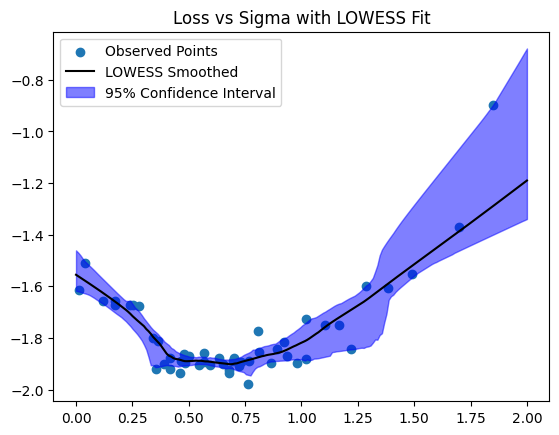

In [38]:
import wandb
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
from datetime import datetime


def lowess_with_confidence_bounds(x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling.
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Bootstrap resampling for confidence intervals
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]
        smoothed_values[i, :] = sm.nonparametric.lowess(exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw)
        

    # Confidence intervals
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


# Initialize a W&B run
with wandb.init(name=f"HPO_visualization_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    # Generate data, fit and plot
    completed_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
    trials_data = [{"sigma": trial.params["sigma"], "loss": trial.value, "trial_id": tid} for tid,trial in enumerate(completed_trials)]
    data = pd.DataFrame(trials_data)
    data = pd.DataFrame(trials_data)
    eval_x = np.linspace(0, 2, 200)
    smoothed, bottom, top = lowess_with_confidence_bounds(data.sigma, data.loss, eval_x, lowess_kw={"frac": 0.33})

    # Create plot

    fig, ax = plt.subplots()
    ax.scatter(data["sigma"], data["loss"], label="Observed Points")
    ax.plot(eval_x, smoothed, 'k', label="LOWESS Smoothed")
    ax.fill_between(eval_x, bottom, top, color='blue', alpha=0.5, label="95% Confidence Interval")
    ax.legend()
    ax.set_title("Loss vs Sigma with LOWESS Fit")
    
    # Log the plot to W&B
    run.log({"LOWESS Plot": wandb.Image(fig)})

    # Additional data to log
    smoothed_best_sigma = eval_x[np.argmin(smoothed)]  # Use the smoothed minimum
    run.log({"best_params": study.best_params, "smoothed_best_sigma": smoothed_best_sigma})
    smooth_best = {"sigma": smoothed_best_sigma}
    print("smooth_best:", smooth_best, "simple_best_param:",study.best_params)

## CMA-ES最適化
### 発見されたパラメータを用いて、より大規模なCMA-ES最適化を実行する
HPOで見つかったシグマの値が効果的であることが確認できたため、分子集団のサイズとステップ数を増やし、最後により大規模な最適化を実行します。

### 結果の探索
最適化のパフォーマンスを評価するために、生成された無効なサンプルの数を定量化することができます。「無効」とは、化学的に有効な分子を表さないSMILES文字列を指します。
実行後、ターゲット（QEDおよびタニモト類似度）の成分が各イテレーションでどのように変化したかを示すグラフを作成します。ターゲットの定義により、タニモト類似度が0.4以上の値が最適とされるため、その値の周囲にノイズが発生することが予想されます。同様に、QEDにおいても0.9以上の値が最適とされるため、その閾値を超える分子がある場合にはその値の周囲にノイズが発生することが予想されます。
WandBで結果を確認しましょう。

### 最適化のパフォーマンスはどれほど良かったのか？
最適化のパフォーマンスを評価するために、生成された無効なサンプルの数を定量化することができます。「無効」とは、化学的に有効な分子を表さないSMILES文字列を指します。

-> wandb内の`num_of_bad_samples`を確認しましょう

最終的に、ベースライン値に対するQEDの改善度と、望ましいタニモト類似度の閾値0.4以上を維持した最適化された分子の割合を定量化することができます。

-> wandb内の`mean_qed_improvement`、`tanimoto_above_04`を確認しましょう。

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=214428, Wed Jul 17 02:18:01 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=214141, Wed Jul 17 02:18:01 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=224003, Wed Jul 17 02:18:01 2024)


  0%|                                                                                                                                                        | 0/30 [00:00<?, ?it/s]

[NeMo I 2024-07-17 02:18:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


  3%|████▊                                                                                                                                           | 1/30 [00:04<02:09,  4.47s/it]

[NeMo I 2024-07-17 02:18:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


  7%|█████████▌                                                                                                                                      | 2/30 [00:09<02:06,  4.53s/it]

[NeMo I 2024-07-17 02:18:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 10%|██████████████▍                                                                                                                                 | 3/30 [00:13<02:04,  4.60s/it]

[NeMo I 2024-07-17 02:18:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 13%|███████████████████▏                                                                                                                            | 4/30 [00:18<01:57,  4.53s/it]

[NeMo I 2024-07-17 02:18:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 17%|████████████████████████                                                                                                                        | 5/30 [00:22<01:53,  4.55s/it]

[NeMo I 2024-07-17 02:18:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 20%|████████████████████████████▊                                                                                                                   | 6/30 [00:27<01:47,  4.48s/it]

[NeMo I 2024-07-17 02:18:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 23%|█████████████████████████████████▌                                                                                                              | 7/30 [00:31<01:44,  4.56s/it]

[NeMo I 2024-07-17 02:18:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 27%|██████████████████████████████████████▍                                                                                                         | 8/30 [00:36<01:39,  4.52s/it]

[NeMo I 2024-07-17 02:18:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 30%|███████████████████████████████████████████▏                                                                                                    | 9/30 [00:41<01:37,  4.63s/it]

[NeMo I 2024-07-17 02:18:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 33%|███████████████████████████████████████████████▋                                                                                               | 10/30 [00:45<01:32,  4.63s/it]

[NeMo I 2024-07-17 02:18:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 37%|████████████████████████████████████████████████████▍                                                                                          | 11/30 [00:50<01:28,  4.67s/it]

[NeMo I 2024-07-17 02:18:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 12/30 [00:55<01:23,  4.63s/it]

[NeMo I 2024-07-17 02:18:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 13/30 [00:59<01:19,  4.65s/it]

[NeMo I 2024-07-17 02:19:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 14/30 [01:04<01:14,  4.63s/it]

[NeMo I 2024-07-17 02:19:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 15/30 [01:09<01:10,  4.68s/it]

[NeMo I 2024-07-17 02:19:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 16/30 [01:13<01:04,  4.64s/it]

[NeMo I 2024-07-17 02:19:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 17/30 [01:18<01:00,  4.63s/it]

[NeMo I 2024-07-17 02:19:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 18/30 [01:22<00:54,  4.57s/it]

[NeMo I 2024-07-17 02:19:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 19/30 [01:27<00:50,  4.57s/it]

[NeMo I 2024-07-17 02:19:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 20/30 [01:31<00:45,  4.55s/it]

[NeMo I 2024-07-17 02:19:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 21/30 [01:36<00:41,  4.58s/it]

[NeMo I 2024-07-17 02:19:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 22/30 [01:40<00:36,  4.57s/it]

[NeMo I 2024-07-17 02:19:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 23/30 [01:45<00:32,  4.62s/it]

[NeMo I 2024-07-17 02:19:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 24/30 [01:50<00:27,  4.61s/it]

[NeMo I 2024-07-17 02:19:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 25/30 [01:55<00:23,  4.66s/it]

[NeMo I 2024-07-17 02:19:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 26/30 [01:59<00:18,  4.63s/it]

[NeMo I 2024-07-17 02:20:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 27/30 [02:04<00:14,  4.68s/it]

[NeMo I 2024-07-17 02:20:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 28/30 [02:08<00:09,  4.65s/it]

[NeMo I 2024-07-17 02:20:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29/30 [02:13<00:04,  4.69s/it]

[NeMo I 2024-07-17 02:20:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.61s/it]


num_of_bad_samples: 0.0008602150537634409 mean_qed_improvement: 0.4664298727924203 tanimoto_above_04: 0.3333333333333333


mean_qed_improvement,▁
num_of_bad_samples,▁
tanimoto_above_04,▁
mean_qed_improvement,0.46643
num_of_bad_samples,0.00086
tanimoto_above_04,0.33333


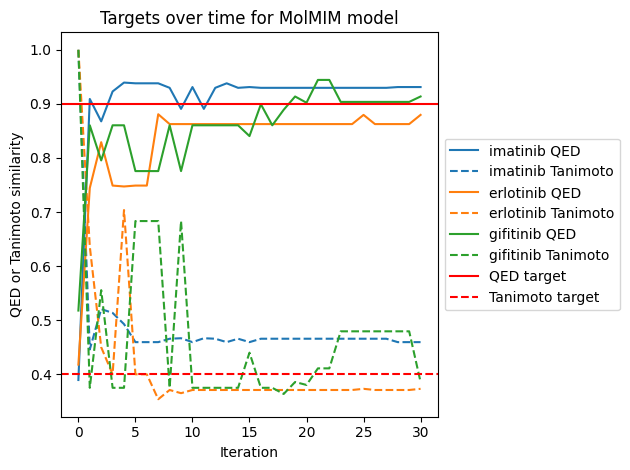

In [39]:
import wandb
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
from tqdm import trange
from datetime import datetime

# Initialize a W&B run
with wandb.init(name=f"CMS_EA_Optimization_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    # Assuming model_wrapped and scoring_function are defined elsewhere
    optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=50,  # larger values will be slower but more thorough
        optimizer_args=smooth_best,  # Vals from HPO
    )
    
    columns = ["iteration", "idx","molecure", "smiles", "structure", "qud_score", "tanimoto_score"]
    optimization_results = wandb.Table(columns=columns)

    # Starting state for idx 0
    qed_scores = [qed(canonicalized_smiles)]
    tanimoto_scores = [[tanimoto_similarity([canonicalized_smiles[idx]], canonicalized_smiles[idx])[0] for idx in range(len(canonicalized_smiles))]]
    best_molecules = [canonicalized_smiles]
    fraction_bad_samples = [[0] * len(canonicalized_smiles)]

    for i in trange(30):
        optimizer.step()
        final_smiles = optimizer.generated_smis
        # Population of molecules is returned, but we only want the best one.
        _qed_scores = []
        _tanimoto_scores = []
        _best_molecules = []
        _fraction_bad = []
        ca_id = 0
        for smis_population, reference_smis in zip(final_smiles, canonicalized_smiles):
            idx = np.argmin(scoring_function(smis_population, reference_smis))
            _fraction_bad.append(np.mean(qed(smis_population) == 0))
            _best_molecules.append(smis_population[idx])
            _qed_scores.append(qed([smis_population[idx]])[0])
            _tanimoto_scores.append(tanimoto_similarity([smis_population[idx]], reference_smis)[0])
            
            
            mol = Chem.MolFromSmiles(smis_population[idx])
            wandb_molecule = wandb.Molecule.from_rdkit(mol)
            
            optimization_results.add_data(i, idx,["imatinib", "erlotinib", "gifitinib"][ca_id], smis_population[idx], wandb_molecule, qed([smis_population[idx]])[0], tanimoto_similarity([smis_population[idx]], reference_smis)[0])
            ca_id=+1

        qed_scores.append(_qed_scores)
        tanimoto_scores.append(_tanimoto_scores)
        best_molecules.append(_best_molecules)
        fraction_bad_samples.append(_fraction_bad)

    run.log({"optimization_results":optimization_results})

    # Plotting results
    fig, ax = plt.subplots()
    for i, molecule in enumerate(["imatinib", "erlotinib", "gifitinib"]):
        line, = plt.plot(np.arange(len(qed_scores)), [q[i] for q in qed_scores], label=f"{molecule} QED")
        color = line.get_color()
        plt.plot(np.arange(len(tanimoto_scores)), [t[i] for t in tanimoto_scores], label=f"{molecule} Tanimoto", linestyle="--", color=color)
    plt.axhline(y=0.9, color='r', linestyle='-', label="QED target")
    plt.axhline(y=0.4, color='r', linestyle='--', label="Tanimoto target")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Iteration")
    plt.ylabel("QED or Tanimoto similarity")
    plt.title("Targets over time for MolMIM model")
    plt.tight_layout()

    # Log the plot to W&B
    run.log({"LOWESS Plot": wandb.Image(fig)})

    # Additional calculations and logs
    qed_improvements = []
    tanimoto_above_04 = []
    for i in range(len(starting_qed)):
        tanimoto_above_04.append(tanimoto_scores[-1][i] >= 0.4)
        qed_improvements.append(qed_scores[-1][i] - starting_qed[i])
    
    metrics = {
        "num_of_bad_samples": np.mean(fraction_bad_samples),
        "mean_qed_improvement": np.mean(qed_improvements),
        "tanimoto_above_04": np.mean(tanimoto_above_04),
    }
    
    run.log(metrics)
    
    # Print metrics
    print("num_of_bad_samples:", np.mean(fraction_bad_samples),"mean_qed_improvement:", metrics["mean_qed_improvement"], "tanimoto_above_04:", metrics["tanimoto_above_04"])
